# Agentic Feature Extraction Analysis

This notebook analyzes the results of the Agentic Feature Extractor applied to computer hardware products. We aim to:

1. **Improve Data Preparation:** Optimize preprocessing steps for efficiency and correctness.
2. **Confirm Cost Calculations:** Ensure cost calculations are accurate and consistent with previous approaches.
3. **Exploratory Data Analysis:** Provide insightful visualizations and analyses to understand the dataset better.


---

## Table of Contents

1. [Setup and Data Loading](#1)
2. [Data Preprocessing](#2)
3. [Feature Extraction Overview](#3)
4. [Cost Calculations](#4)
5. [Exploratory Data Analysis](#5)
    - [5.1 Missing Data Analysis](#5.1)
    - [5.2 Cost and Time Distribution](#5.2)
    - [5.3 Iterative Extraction Analysis](#5.3)
    - [5.4 Feature Extraction Success Rates](#5.4)
6. [Conclusion](#6)
7. [Save Processed Data](#7)



---

## 1. Setup and Data Loading <a id="1"></a>

We start by importing necessary libraries and loading the result data files.


In [1]:
import os
import ast
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Set up display options and styles
sns.set(style="whitegrid")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)
pd.set_option('display.float_format', '{:.4f}'.format)

# Configure logging
logging.basicConfig(level=logging.ERROR, force=True)

In [2]:
# Define data folder and load result files
data_folder = "../data/feature_extraction"
result_files = [f for f in os.listdir(data_folder) if f.startswith("result_df_") and f.endswith(".csv")]

# Load all result DataFrames
dfs = []
for file in result_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Combine all result DataFrames
_results_df = pd.concat(dfs, ignore_index=True)
_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1563 entries, 0 to 1562
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   id                                    1563 non-null   object
 1   extracted_data                        1563 non-null   object
 2   usage_data                            1563 non-null   object
 3   missing_feature_count_history         1563 non-null   object
 4   low_confidence_feature_count_history  1563 non-null   object
dtypes: object(5)
memory usage: 61.2+ KB


In [3]:
# get duplicate products based on product_id
duplicates = _results_df[_results_df["id"].duplicated(keep=False)]
duplicates.head()

,id,extracted_data,usage_data,missing_feature_count_history,low_confidence_feature_count_history


In [4]:

# Drop rows where extracted_data is missing or empty
results_df = _results_df[_results_df["extracted_data"].notna()]
results_df = results_df[results_df["extracted_data"] != "{}"]

# Reset index after filtering
results_df.reset_index(drop=True, inplace=True)

# Display the first few rows
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   id                                    1061 non-null   object
 1   extracted_data                        1061 non-null   object
 2   usage_data                            1061 non-null   object
 3   missing_feature_count_history         1061 non-null   object
 4   low_confidence_feature_count_history  1061 non-null   object
dtypes: object(5)
memory usage: 41.6+ KB


---



## 2. Data Preprocessing <a id="2"></a>

We perform several preprocessing steps to prepare the data for analysis.


### 2.1 Post-process Extracted Features

We define a function to clean and standardize the `extracted_data` field.


In [5]:
def post_process_extracted_features(extracted_data):
    if isinstance(extracted_data, str):
        extracted_data = ast.literal_eval(extracted_data)

    if "io_count" in extracted_data:
        if isinstance(extracted_data["io_count"], dict):
            extracted_data["io_count"] = [f"{key}: {value}" for key, value in extracted_data["io_count"].items()]
        elif isinstance(extracted_data["io_count"], (int, str)):
            extracted_data["io_count"] = [str(extracted_data["io_count"])]

    return extracted_data


In [6]:
# Apply post-processing to extracted_data
results_df["extracted_data"] = results_df["extracted_data"].apply(post_process_extracted_features)


### 2.2 Expand Extracted Data

We expand the `extracted_data` column into separate features.


In [7]:
# Expand extracted_data into separate columns
extracted_df = pd.json_normalize(results_df["extracted_data"])

# Concatenate with the original DataFrame
full_df = pd.concat([results_df.drop(["extracted_data"], axis=1), extracted_df], axis=1)

full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   id                                    1061 non-null   object
 1   usage_data                            1061 non-null   object
 2   missing_feature_count_history         1061 non-null   object
 3   low_confidence_feature_count_history  1061 non-null   object
 4   name                                  1061 non-null   object
 5   manufacturer                          1061 non-null   object
 6   form_factor                           1061 non-null   object
 7   evaluation_or_commercialization       1061 non-null   object
 8   processor_architecture                1061 non-null   object
 9   processor_core_count                  1061 non-null   object
 10  processor_manufacturer                1061 non-null   object
 11  processor_tdp                 

### 2.3 Handle Missing Values

We replace placeholders like 'Not Available' and 'None' with `NaN` and infer data types.


In [8]:
# Replace placeholders with NaN and infer data types
full_df = full_df.replace(['Not Available', None, 'None', 'NOT AVAILABLE'], np.nan).infer_objects()
extracted_df = extracted_df.replace(['Not Available', None, 'None', 'NOT AVAILABLE'], np.nan).infer_objects()

# Drop rows where essential features are missing
essential_features = ["name", "manufacturer", "form_factor"]
full_df.dropna(subset=essential_features, inplace=True)
extracted_df.dropna(subset=essential_features, inplace=True)


# Drop rows where there are more than 5 missing features in extracted_df, meaning columns "name", "manufacturer", and "form_factor", have values, but other columns are missing
full_df = full_df[full_df.isna().sum(axis=1) <= 4]
extracted_df = extracted_df[extracted_df.isna().sum(axis=1) <= 4]

# Reset index after dropping
full_df.reset_index(drop=True, inplace=True)
extracted_df.reset_index(drop=True, inplace=True)

# Display info about the processed DataFrame
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   id                                    979 non-null    object
 1   usage_data                            979 non-null    object
 2   missing_feature_count_history         979 non-null    object
 3   low_confidence_feature_count_history  979 non-null    object
 4   name                                  979 non-null    object
 5   manufacturer                          979 non-null    object
 6   form_factor                           979 non-null    object
 7   evaluation_or_commercialization       978 non-null    object
 8   processor_architecture                967 non-null    object
 9   processor_core_count                  913 non-null    object
 10  processor_manufacturer                977 non-null    object
 11  processor_tdp                   

### 2.4 Flatten Usage Data

We define a function to flatten the `usage_data` field and calculate costs.


In [9]:
# Constants for pricing (Assuming GPT-4o pricing)
INPUT_TOKEN_COST =  0.0000025  # $2.50 per million tokens
OUTPUT_TOKEN_COST = 0.00001   # $10.00 per million tokens

In [10]:
def flatten_usage_data(usage, product_id):
    usage_records = []
    usage_dict = ast.literal_eval(usage) if isinstance(usage, str) else usage
    for step, usages in usage_dict.items():
        for idx, usage_entry in enumerate(usages, 1):
            record = {
                "product_id": product_id,
                "Step": f"{step} ({idx})",
                "input_tokens": usage_entry.get("input_tokens", 0),
                "output_tokens": usage_entry.get("output_tokens", 0),
                "time_taken": usage_entry.get("time_taken", 0.0),
            }
            # Calculate cost
            input_cost = usage_entry.get("input_tokens", 0) * INPUT_TOKEN_COST
            output_cost = usage_entry.get("output_tokens", 0) * OUTPUT_TOKEN_COST
            total_cost = input_cost + output_cost
            record["cost"] = total_cost
            usage_records.append(record)
    return pd.DataFrame(usage_records)

# Flatten usage data for each product
usage_dfs = []
for product_id, usage_data in zip(full_df["id"], full_df["usage_data"]):
    usage_df = flatten_usage_data(usage_data, product_id)
    usage_dfs.append(usage_df)

# Concatenate all usage DataFrames
usage_df = pd.concat(usage_dfs, ignore_index=True)

# Display the first few rows of the flattened usage DataFrame
usage_df.head(10)


,product_id,Step,input_tokens,output_tokens,time_taken,cost
0,iW-G27S-SCQM-4L004G-E016G-BIC,store_and_chunk_data (1),0,0,1.4518,0.0000
1,iW-G27S-SCQM-4L004G-E016G-BIC,generate_missing_features (1),4569,30,1.9366,0.0117
2,iW-G27S-SCQM-4L004G-E016G-BIC,generate_missing_features (2),4516,30,2.6675,0.0116
3,iW-G27S-SCQM-4L004G-E016G-BIC,search_missing_features (1),0,0,16.3740,0.0000
4,iW-G27S-SCQM-4L004G-E016G-BIC,search_missing_features (2),0,0,12.5520,0.0000
5,iW-G27S-SCQM-4L004G-E016G-BIC,extract_features (1),2342,861,9.7270,0.0145
6,conga-TC170slash3955U,store_and_chunk_data (1),0,0,1.5673,0.0000
7,conga-TC170slash3955U,generate_missing_features (1),3687,99,2.9588,0.0102
8,conga-TC170slash3955U,generate_missing_features (2),3509,110,4.0293,0.0099
9,conga-TC170slash3955U,generate_missing_features (3),4414,87,3.6600,0.0119


In [11]:
# Extract relevant steps for analysis
usage_df = usage_df[usage_df["Step"].str.contains("extract_features|generate_missing_features")].copy()


# Rename and reorder steps
def map_step(step):
    if "extract_features" in step:
        return "Extract"
    elif "generate_missing_features" in step:
        attempt = step.split("(")[-1].split(")")[0]
        return f"Attempt {attempt}"
    return step


usage_df["Step"] = usage_df["Step"].apply(map_step)

# Sort steps
usage_df = usage_df.sort_values(
    ["product_id", "Step"],
    key=lambda x: pd.Categorical(x, ["Extract"] + [f"Attempt {i}" for i in range(1, len(usage_df))]),
)

usage_df.tail(10)

,product_id,Step,input_tokens,output_tokens,time_taken,cost
6730,IMBA-Q170-i2-R10,Attempt 5,4113,75,4.2013,0.0110
6814,EmETX-a55E0-T56N,Attempt 5,4065,30,2.9148,0.0105
6820,PCE-4132G2-00A1,Attempt 5,3420,29,2.8967,0.0088
6852,SOM-D580D12-S8A1,Attempt 5,3654,29,2.2195,0.0094
6963,ASMB-588G4-00A1U,Attempt 5,4048,29,1.9649,0.0104
6991,102110364,Attempt 5,2820,29,3.9619,0.0073
7037,DEVKIT-S12ZVL,Attempt 5,3505,80,3.8934,0.0096
7084,ASMB781G200A1E-ES,Attempt 5,3593,29,2.6045,0.0093
7172,HPC-7400MB-70A1E,Attempt 5,3660,53,5.4848,0.0097
7192,MANO526-Q370 A20 Single Packing,Attempt 5,4004,53,2.9255,0.0105


### 2.5 Process Missing Feature Counts

We process the `missing_feature_count_history` and align it with the usage data.


In [12]:
# Convert missing_feature_count_history to lists
full_df["missing_feature_count_history"] = full_df["missing_feature_count_history"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Ensure each history list aligns with the number of steps in usage data
def align_missing_feature_counts(row):
    history = row["missing_feature_count_history"]
    usage_steps = usage_df[usage_df["product_id"] == row["id"]]["Step"].tolist()
    steps = ["Extract"] + [f"Attempt {i}" for i in range(1, len(history))]
    count_dict = dict(zip(steps, history))
    return count_dict

# Create a mapping of product_id to step-wise missing feature counts
missing_feature_counts = full_df.apply(align_missing_feature_counts, axis=1)
missing_feature_counts = dict(zip(full_df["id"], missing_feature_counts))


### 2.6 Add Missing Features to Usage Data

We merge the missing feature counts into the usage DataFrame.


In [13]:
# Map missing features to usage_df
def map_missing_features(row):
    counts = missing_feature_counts.get(row["product_id"], {})
    step_name = row["Step"].split(" (")[0]  # Extract step name without index
    return counts.get(step_name)

usage_df["missing_features"] = usage_df.apply(map_missing_features, axis=1)
usage_df.head(10)


,product_id,Step,input_tokens,output_tokens,time_taken,cost,missing_features
5,iW-G27S-SCQM-4L004G-E016G-BIC,Extract,2342,861,9.7270,0.0145,1
15,conga-TC170slash3955U,Extract,2131,801,8.5259,0.0133,4
23,34012-0416-N1-2,Extract,2121,687,7.9494,0.0122,5
29,conga-TCA7slashi-x6212RE,Extract,2354,773,8.5617,0.0136,3
30,MIC-7700H-00A1,Extract,2107,749,7.5286,0.0128,2
36,S26361-F5120-V175,Extract,2353,792,7.6445,0.0138,2
40,conga-QA5slashE3930-2G eMMC16,Extract,2694,683,6.7548,0.0136,2
48,AIIS-3400P-00A1E,Extract,1577,769,11.0549,0.0116,3
54,CAPA13RPH4G-V1605B,Extract,1645,785,10.6443,0.0120,5
66,SOM-3569CN0C-S1A1,Extract,1584,784,10.8405,0.0118,3


/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_16674/3612165134.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=usage_df, x="Step", y="cost", estimator=np.mean, ci=None)


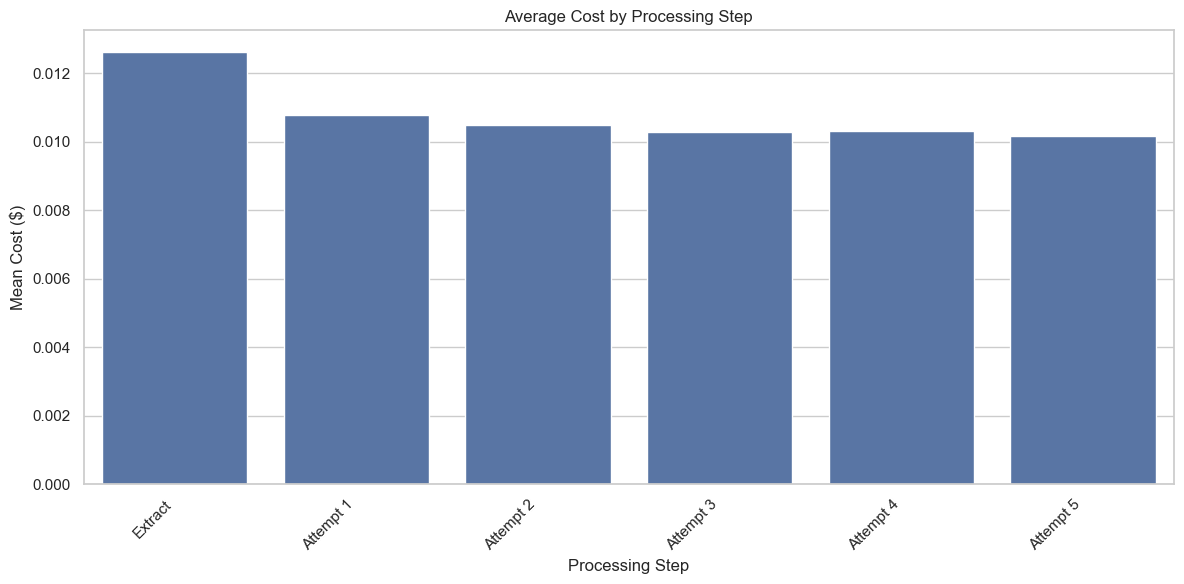

In [41]:
# Visualize the mean cost for different steps
plt.figure(figsize=(12, 6))
sns.barplot(data=usage_df, x="Step", y="cost", estimator=np.mean, ci=None)
plt.title("Average Cost by Processing Step")
plt.ylabel("Mean Cost ($)")
plt.xlabel("Processing Step")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_16674/151434614.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=usage_df, x="Step", y="missing_features", estimator=np.mean, ci=None)


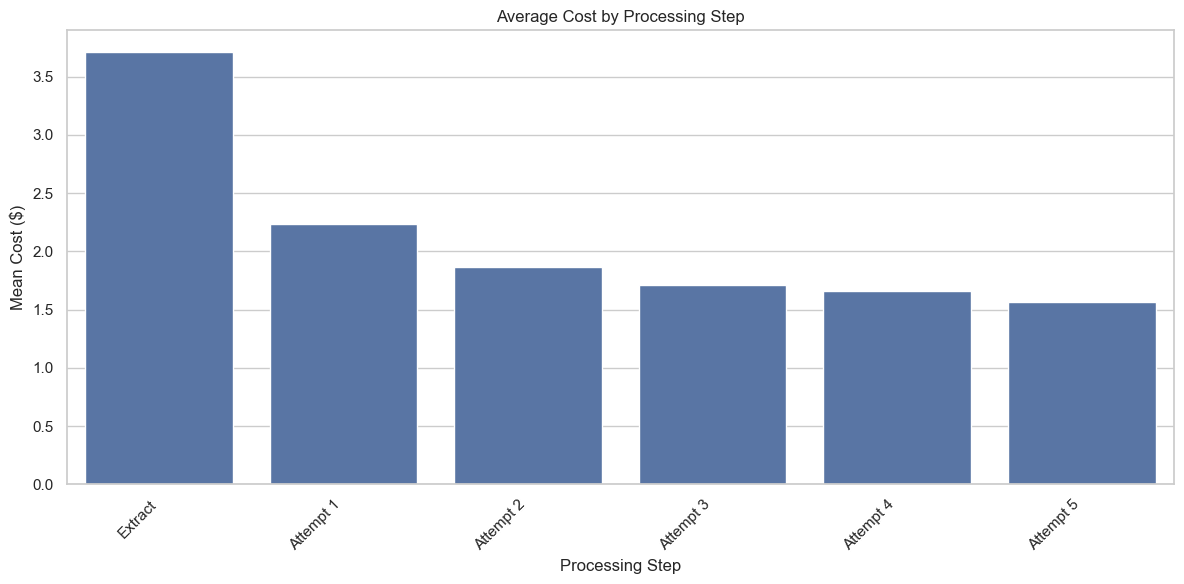

In [42]:
# Visualize the mean cost for different steps
plt.figure(figsize=(12, 6))
sns.barplot(data=usage_df, x="Step", y="missing_features", estimator=np.mean, ci=None)
plt.title("Average Cost by Processing Step")
plt.ylabel("Mean Cost ($)")
plt.xlabel("Processing Step")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



---


## 3. Failed extraction total cost <a id="3"></a>

We provide the total cost of failed extraction.





In [14]:
failed_df = _results_df[~_results_df["id"].isin(results_df["id"])]
failed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 7 to 1561
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   id                                    502 non-null    object
 1   extracted_data                        502 non-null    object
 2   usage_data                            502 non-null    object
 3   missing_feature_count_history         502 non-null    object
 4   low_confidence_feature_count_history  502 non-null    object
dtypes: object(5)
memory usage: 23.5+ KB


In [15]:
failed_df2 = results_df[~results_df["id"].isin(full_df["id"])]
failed_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82 entries, 1 to 1035
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   id                                    82 non-null     object
 1   extracted_data                        82 non-null     object
 2   usage_data                            82 non-null     object
 3   missing_feature_count_history         82 non-null     object
 4   low_confidence_feature_count_history  82 non-null     object
dtypes: object(5)
memory usage: 3.8+ KB


In [16]:
def calculate_cost_and_time(usage_data):
    total_input_tokens = 0
    total_output_tokens = 0
    total_time = 0.0

    usage_dict = ast.literal_eval(usage_data) if isinstance(usage_data, str) else usage_data
    for usage_list in usage_dict.values():
        for usage in usage_list:
            total_input_tokens += usage.get("input_tokens", 0)
            total_output_tokens += usage.get("output_tokens", 0)
            total_time += usage.get("time_taken", 0.0)

    input_cost = total_input_tokens * INPUT_TOKEN_COST
    output_cost = total_output_tokens * OUTPUT_TOKEN_COST
    total_cost = input_cost + output_cost

    return total_cost, total_time, total_input_tokens, total_output_tokens


In [17]:
failed_df[["total_cost", "total_time", "total_input_tokens", "total_output_tokens"]] = failed_df["usage_data"].apply(
    lambda x: pd.Series(calculate_cost_and_time(x))
)

failed_df2[["total_cost", "total_time", "total_input_tokens", "total_output_tokens"]] = failed_df2["usage_data"].apply(
    lambda x: pd.Series(calculate_cost_and_time(x))
)

/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_16674/1170998479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_df[["total_cost", "total_time", "total_input_tokens", "total_output_tokens"]] = failed_df["usage_data"].apply(
/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_16674/1170998479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_df[["total_cost", "total_time", "total_input_tokens", "total_output_tokens"]] = failed_df["usage_data"].apply(
/var/folders/rp/6b0g

In [18]:
# print sum of total_cost
print(f"Total cost: ${failed_df['total_cost'].sum():.2f}")
print(f"Total cost: ${failed_df2['total_cost'].sum():.2f}")

Total cost: $8.68
Total cost: $3.56



---



## 4. Cost Calculations <a id="4"></a>

We confirm that cost calculations follow the same approach as before.


In [19]:

# Calculate cost and time for each product
full_df[["total_cost", "total_time", "total_input_tokens", "total_output_tokens"]] = full_df["usage_data"].apply(
    lambda x: pd.Series(calculate_cost_and_time(x))
)

# Print overall statistics
print(f"Total cost: ${full_df['total_cost'].sum():.2f}")
print(f"Average cost per product: ${full_df['total_cost'].mean():.4f}")
print(f"Total time: {full_df['total_time'].sum() / 3600:.2f} hours")
print(f"Average time per product: {full_df['total_time'].mean():.2f} seconds")
print(f"Total input tokens: {full_df['total_input_tokens'].sum():,.0f}")
print(f"Total output tokens: {full_df['total_output_tokens'].sum():,.0f}")


Total cost: $40.80
Average cost per product: $0.0417
Total time: 21.73 hours
Average time per product: 79.91 seconds
Total input tokens: 12,477,020
Total output tokens: 960,589


In [20]:
0.04* 1600

64.0

---


## 5. Exploratory Data Analysis <a id="5"></a>

We perform exploratory analyses to gain insights into the dataset.



### 5.1 Missing Data Analysis <a id="5.1"></a>



#### 5.1.1 Missing Rates per Feature


In [21]:
# Calculate missing rate for each feature
missing_rates = extracted_df.isna().mean().sort_values(ascending=False)

# Display missing rates
print("Missing rates for each feature:")
display(missing_rates)


Missing rates for each feature:


processor_tdp                     0.3728
wireless                          0.3269
certifications                    0.2257
operating_system_bsp              0.1113
onboard_storage                   0.0746
processor_core_count              0.0674
input_voltage                     0.0306
operating_temperature_min         0.0194
operating_temperature_max         0.0153
processor_architecture            0.0123
target_applications               0.0082
memory                            0.0020
processor_manufacturer            0.0020
evaluation_or_commercialization   0.0010
io_count                          0.0000
manufacturer                      0.0000
form_factor                       0.0000
short_summary                     0.0000
full_summary                      0.0000
full_product_description          0.0000
name                              0.0000
dtype: float64

#### 5.1.2 Visualize Missing Rates


/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_16674/3497305802.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_rates.index, y=missing_rates.values, palette="viridis")


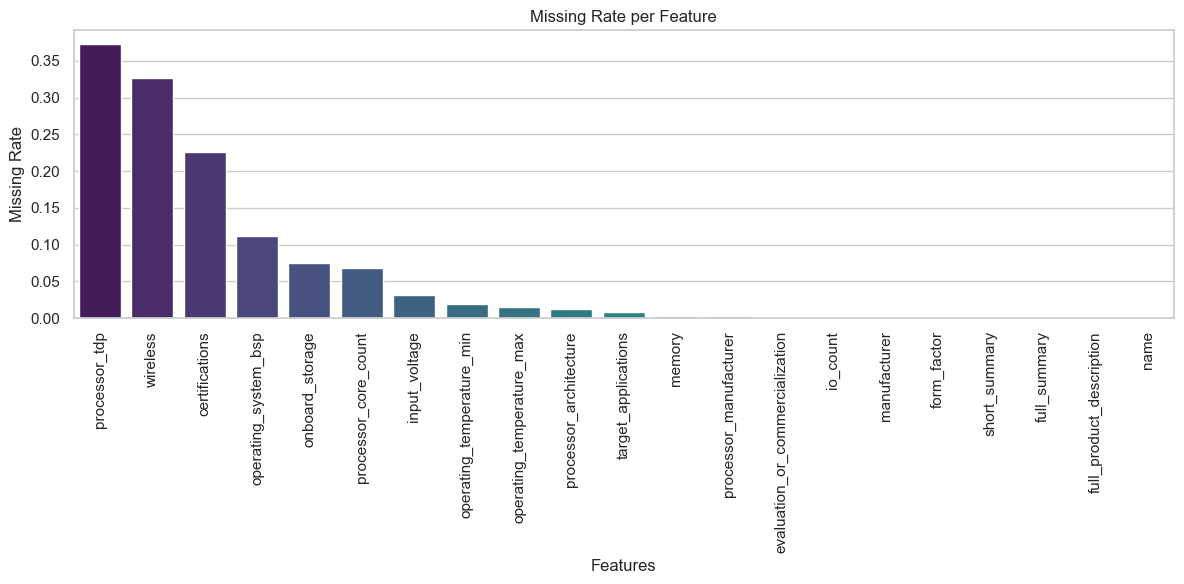

In [22]:
# Visualize missing rates
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_rates.index, y=missing_rates.values, palette="viridis")
plt.title("Missing Rate per Feature")
plt.xlabel("Features")
plt.ylabel("Missing Rate")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#### 5.1.3 Missing Rates per product

In [23]:
# Calculate missing features per product
missing_per_product = extracted_df.isna().sum(axis=1)

# Calculate average number of missing features per product
avg_missing_per_product = missing_per_product.mean()

# Count products with no missing features
products_no_missing = (missing_per_product == 0).sum()

print(f"Average number of missing features per product: {avg_missing_per_product:.2f}")
print(f"Number of products with no missing features: {products_no_missing}")
print(f"Percentage of products with no missing features: {(products_no_missing / len(extracted_df)) * 100:.2f}%")

Average number of missing features per product: 1.27
Number of products with no missing features: 325
Percentage of products with no missing features: 33.20%


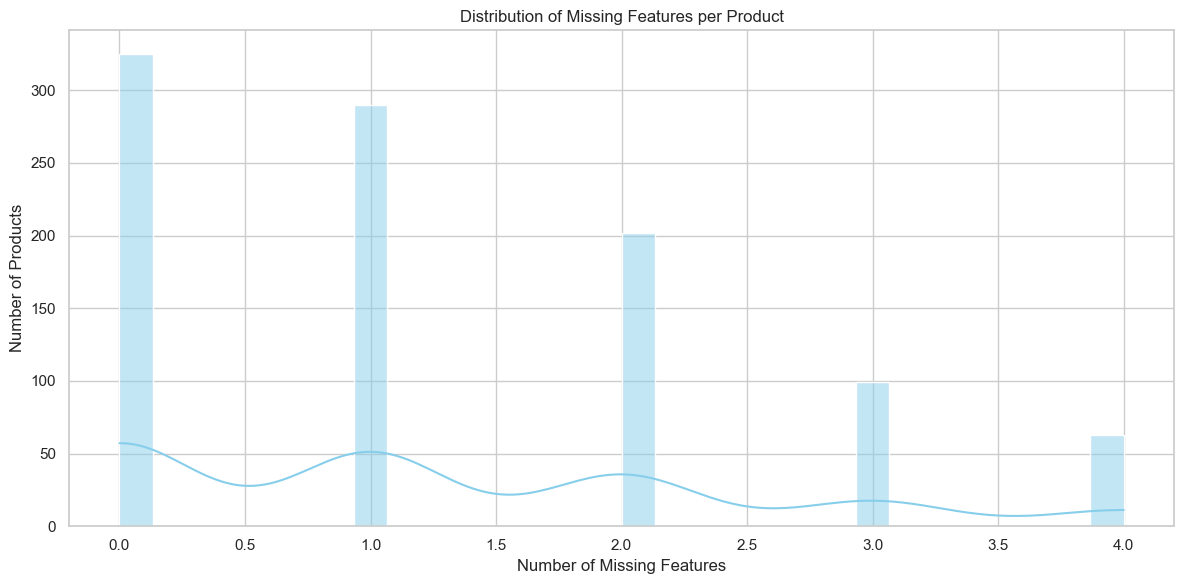

In [24]:
# Visualize distribution of missing features per product
plt.figure(figsize=(12, 6))
sns.histplot(missing_per_product, bins=30, kde=True, color="skyblue")
plt.title("Distribution of Missing Features per Product")
plt.xlabel("Number of Missing Features")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.show()


In [25]:
# Display products with the most missing features
most_missing = missing_per_product.nlargest(10)
print("\nProducts with the most missing features:")
display(most_missing)



Products with the most missing features:


22     4
73     4
85     4
98     4
103    4
106    4
139    4
143    4
164    4
168    4
dtype: int64

In [26]:
# Display products with the highest missing features
products_complete = extracted_df[missing_per_product == 8]
print(f"\nSample of products with no missing features (showing first 10):")
display(products_complete.head(10))


Sample of products with no missing features (showing first 10):


,name,manufacturer,form_factor,evaluation_or_commercialization,processor_architecture,processor_core_count,processor_manufacturer,processor_tdp,memory,onboard_storage,input_voltage,io_count,wireless,operating_system_bsp,operating_temperature_max,operating_temperature_min,certifications,short_summary,full_summary,full_product_description,target_applications


In [27]:
# Display products with no missing features
products_complete = extracted_df[missing_per_product == 0]
print(f"\nSample of products with no missing features (showing first 10):")
display(products_complete.head(10)[["name", "manufacturer", "form_factor"]])


Sample of products with no missing features (showing first 10):


,name,manufacturer,form_factor
1,CONGATC,CONGATEC,COM EXPRESS COMPACT
2,COMEMEL E,KONTRON,COM EXPRESS MINI
4,MIC,ADVANTECH,Compact Fanless System
5,DB MSTX EXTENDED LIFECYCLE SERIES,KONTRON,MINISTX
12,PCM,ADVANTECH,SBC
13,AIMB,ADVANTECH,MICROATX
18,ARK,ADVANTECH,Fanless Embedded Box PC
23,CPU LOW POWER SBC NXP IMX,EUROTECH,SBC
24,RCB,NEXCOBOT,MINI-ITX
27,EAGLE EYES AIHD,AIC,DIN RAIL


### 5.2 Cost and Time Distribution <a id="5.2"></a>


#### 5.2.1 Distribution of Total Cost per Product


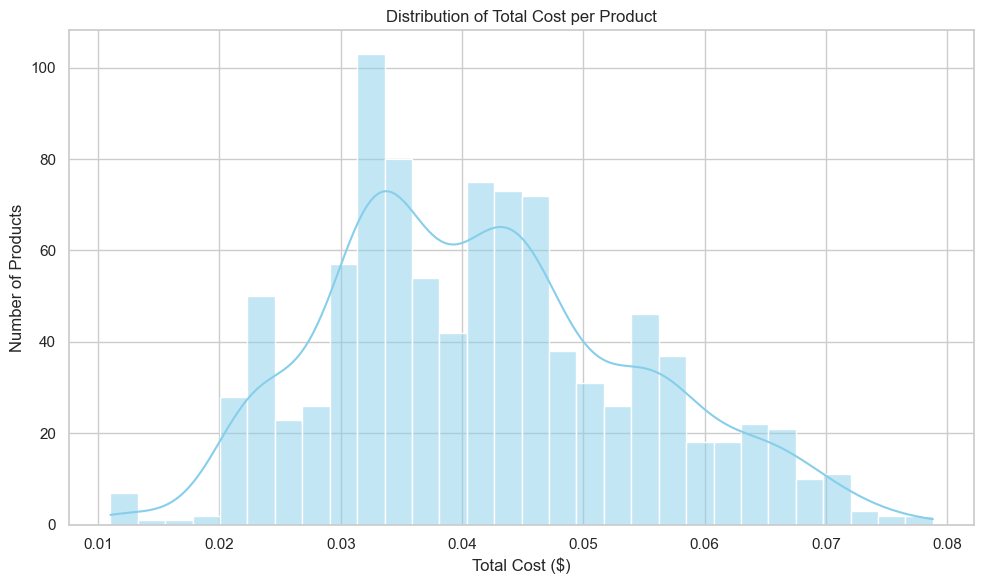

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(full_df['total_cost'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Total Cost per Product")
plt.xlabel("Total Cost ($)")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.show()


In [29]:
# print product with highest cost
full_df[full_df["total_cost"] == full_df["total_cost"].max()]

,id,usage_data,missing_feature_count_history,low_confidence_feature_count_history,name,manufacturer,form_factor,evaluation_or_commercialization,processor_architecture,processor_core_count,processor_manufacturer,processor_tdp,memory,onboard_storage,input_voltage,io_count,wireless,operating_system_bsp,operating_temperature_max,operating_temperature_min,certifications,short_summary,full_summary,full_product_description,target_applications,total_cost,total_time,total_input_tokens,total_output_tokens
681,CYTVII-B-H-8M-320-CPU,"{'extract_features': [{'input_tokens': 4178, 'output_tokens': 600, 'time_taken': 7.592200994491577}], 'generate_missing_features': [{'input_tokens': 4525, 'output_tokens': 307, 'time_taken': 6.93730092048645}, {'input_tokens': 4331, 'output_tokens': 197, 'time_taken': 4.833467245101929}, {'input_tokens': 3769, 'output_tokens': 182, 'time_taken': 4.244003057479858}, {'input_tokens': 4396, 'output_tokens': 99, 'time_taken': 2.868162155151367}, {'input_tokens': 4396, 'output_tokens': 99, 'time_taken': 3.1051509380340576}], 'store_and_chunk_data': [{'input_tokens': 0, 'output_tokens': 0, 'time_taken': 3.104189872741699}], 'search_missing_features': [{'input_tokens': 0, 'output_tokens': 0, 'time_taken': 13.141298055648804}, {'input_tokens': 0, 'output_tokens': 0, 'time_taken': 55.204370975494385}, {'input_tokens': 0, 'output_tokens': 0, 'time_taken': 31.56916093826294}, {'input_tokens': 0, 'output_tokens': 0, 'time_taken': 19.816503047943115}, {'input_tokens': 0, 'output_tokens': 0, 'time_taken': 19.68771529197693}]}","[12, 8, 7, 4, 4, 4]","[0, 0, 0, 0, 0, 0]",CYTVIIBHMCPU,CYPRESS SEMICONDUCTOR,BGA,True,ARM Cortex-A9,Four,ARM,NaN,HSRAM,HFLASH,5.0 V,[Not Available],NaN,Linux,125 °C,-40 °C,NaN,Evaluation board featuring HFLASH and HSRAM.,"The CYTVIIBHMCPU is an evaluation board by Cypress Semiconductor, featuring BGA form factor, HFLASH storage, and HSRAM memory.","The CYTVIIBHMCPU evaluation board by Cypress Semiconductor is designed for testing and development purposes. It includes HFLASH for storage and HSRAM for memory, with a BGA form factor.","HMI, industrial and networking applications",0.0788,172.1035,25595.0000,1484.0000


In [30]:
full_df[full_df["total_cost"] == full_df["total_cost"].max()].values

array([['CYTVII-B-H-8M-320-CPU',
        "{'extract_features': [{'input_tokens': 4178, 'output_tokens': 600, 'time_taken': 7.592200994491577}], 'generate_missing_features': [{'input_tokens': 4525, 'output_tokens': 307, 'time_taken': 6.93730092048645}, {'input_tokens': 4331, 'output_tokens': 197, 'time_taken': 4.833467245101929}, {'input_tokens': 3769, 'output_tokens': 182, 'time_taken': 4.244003057479858}, {'input_tokens': 4396, 'output_tokens': 99, 'time_taken': 2.868162155151367}, {'input_tokens': 4396, 'output_tokens': 99, 'time_taken': 3.1051509380340576}], 'store_and_chunk_data': [{'input_tokens': 0, 'output_tokens': 0, 'time_taken': 3.104189872741699}], 'search_missing_features': [{'input_tokens': 0, 'output_tokens': 0, 'time_taken': 13.141298055648804}, {'input_tokens': 0, 'output_tokens': 0, 'time_taken': 55.204370975494385}, {'input_tokens': 0, 'output_tokens': 0, 'time_taken': 31.56916093826294}, {'input_tokens': 0, 'output_tokens': 0, 'time_taken': 19.816503047943115}, {'inp

#### 5.2.2 Distribution of Total Time per Product


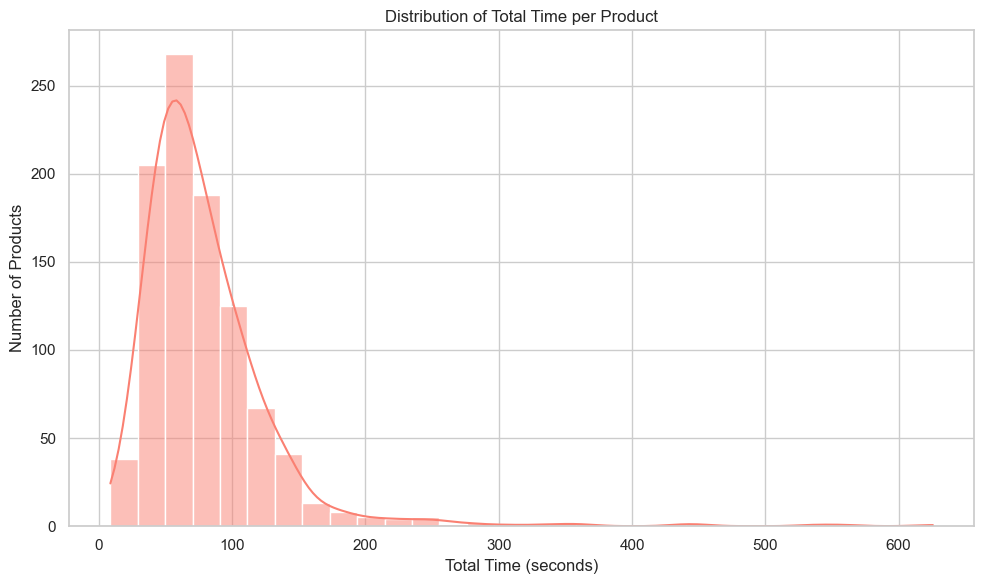

In [31]:

plt.figure(figsize=(10, 6))
sns.histplot(full_df['total_time'], bins=30, kde=True, color='salmon')
plt.title("Distribution of Total Time per Product")
plt.xlabel("Total Time (seconds)")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.show()


### 5.3 Iterative Extraction Analysis <a id="5.3"></a>

We analyze how missing features decrease with each extraction iteration.


/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_16674/2825980412.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_step_costs, x="Step", y="Cost", palette="coolwarm")


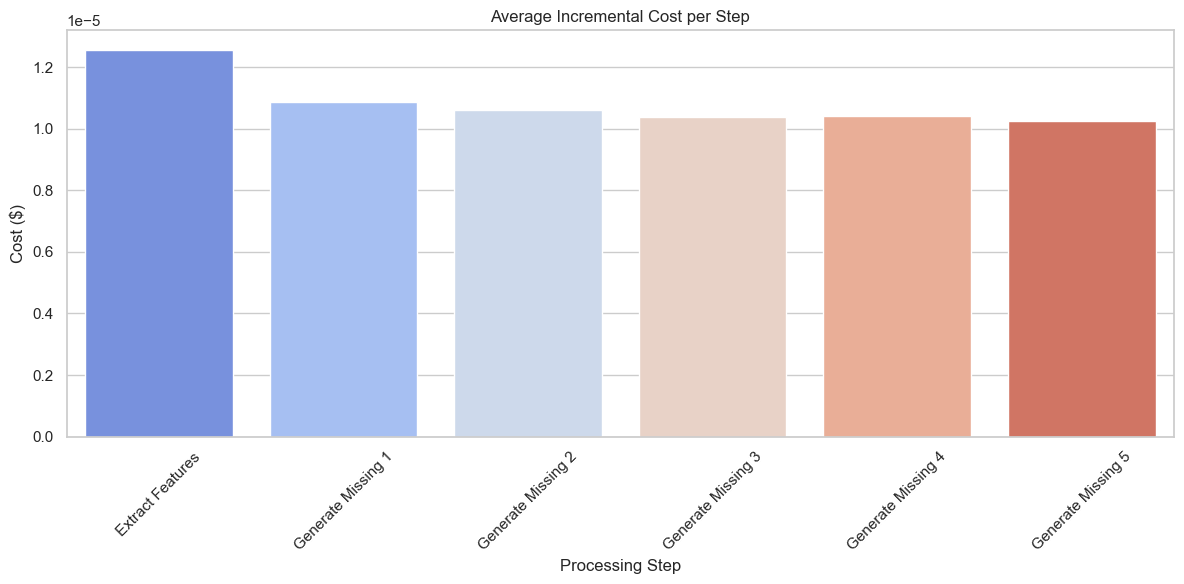

/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_16674/2825980412.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_step_costs, x="Step", y="Time", palette="coolwarm")


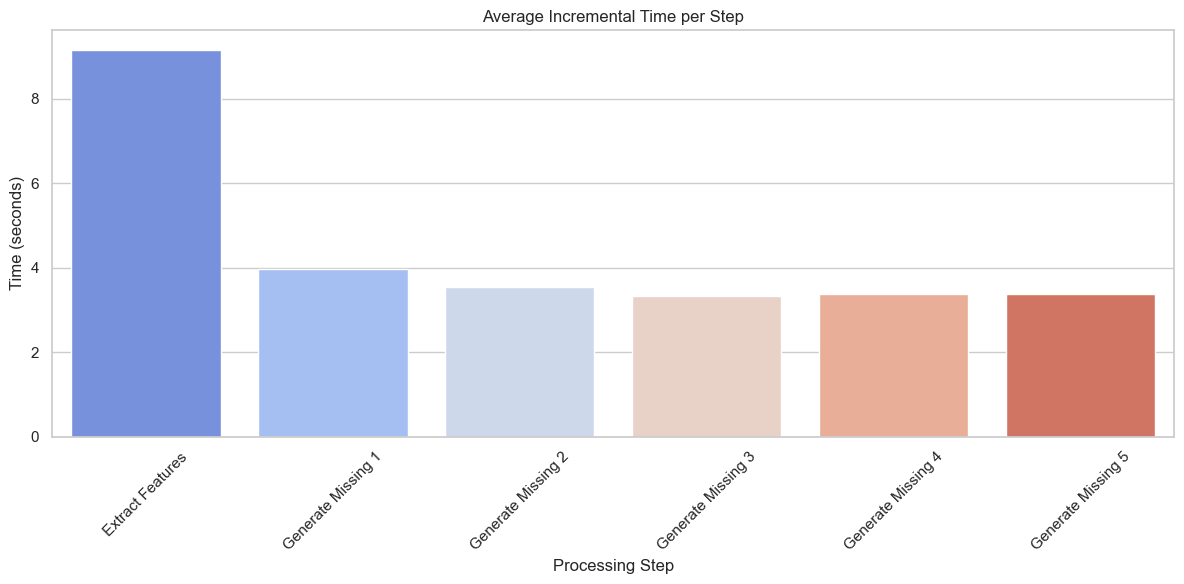

In [40]:
# Function to extract cost and time per step
def extract_step_costs(usage_data):
    usage_dict = ast.literal_eval(usage_data)
    steps = []
    costs = []
    times = []

    # Extract features step
    extract_usage = usage_dict.get("extract_features", [])
    if extract_usage:
        total_input = sum(u.get("input_tokens", 0) for u in extract_usage)
        total_output = sum(u.get("output_tokens", 0) for u in extract_usage)
        total_time = sum(u.get("time_taken", 0.0) for u in extract_usage)
        cost = (total_input * INPUT_TOKEN_COST + total_output * OUTPUT_TOKEN_COST) / 1000
        steps.append("Extract Features")
        costs.append(cost)
        times.append(total_time)

    # Generate missing features steps
    gen_missing_usage = usage_dict.get("generate_missing_features", [])
    for idx, gen_usage in enumerate(gen_missing_usage, 1):
        total_input = gen_usage.get("input_tokens", 0)
        total_output = gen_usage.get("output_tokens", 0)
        total_time = gen_usage.get("time_taken", 0.0)
        cost = (total_input * INPUT_TOKEN_COST + total_output * OUTPUT_TOKEN_COST) / 1000
        steps.append(f"Generate Missing {idx}")
        costs.append(cost)
        times.append(total_time)

    return pd.DataFrame({"Step": steps, "Cost": costs, "Time": times})


# Aggregate incremental cost and time per step across all products
step_costs_list = []
for usage_data in results_df["usage_data"]:
    step_costs_df = extract_step_costs(usage_data)
    step_costs_list.append(step_costs_df)

all_step_costs_df = pd.concat(step_costs_list, ignore_index=True)

# Calculate average cost and time per step
avg_step_costs = all_step_costs_df.groupby("Step").mean().reset_index()

# Visualize incremental cost per step
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_step_costs, x="Step", y="Cost", palette="coolwarm")
plt.title("Average Incremental Cost per Step")
plt.xlabel("Processing Step")
plt.ylabel("Cost ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize incremental time per step
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_step_costs, x="Step", y="Time", palette="coolwarm")
plt.title("Average Incremental Time per Step")
plt.xlabel("Processing Step")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 5.3.1 Average Missing Features per Iteration


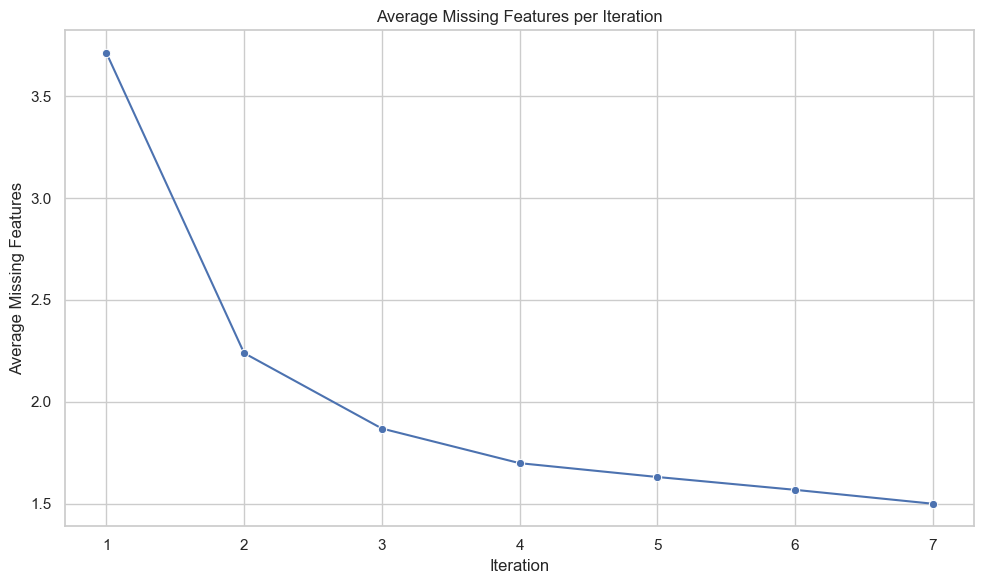

In [32]:
# Extract missing feature counts per iteration
missing_counts_list = []
for counts in full_df["missing_feature_count_history"]:
    missing_counts_list.append(counts)

# Create DataFrame
missing_counts_df = pd.DataFrame(missing_counts_list)

# Calculate average missing features per iteration
avg_missing_counts = missing_counts_df.mean()

# Visualize
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(avg_missing_counts)+1), y=avg_missing_counts, marker='o')
plt.title("Average Missing Features per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Average Missing Features")
plt.xticks(range(1, len(avg_missing_counts)+1))
plt.tight_layout()
plt.show()


#### 5.3.2 Cost per Iteration


/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_16674/1059890745.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=iteration_costs, x="Step", y="cost", palette="Blues_d")


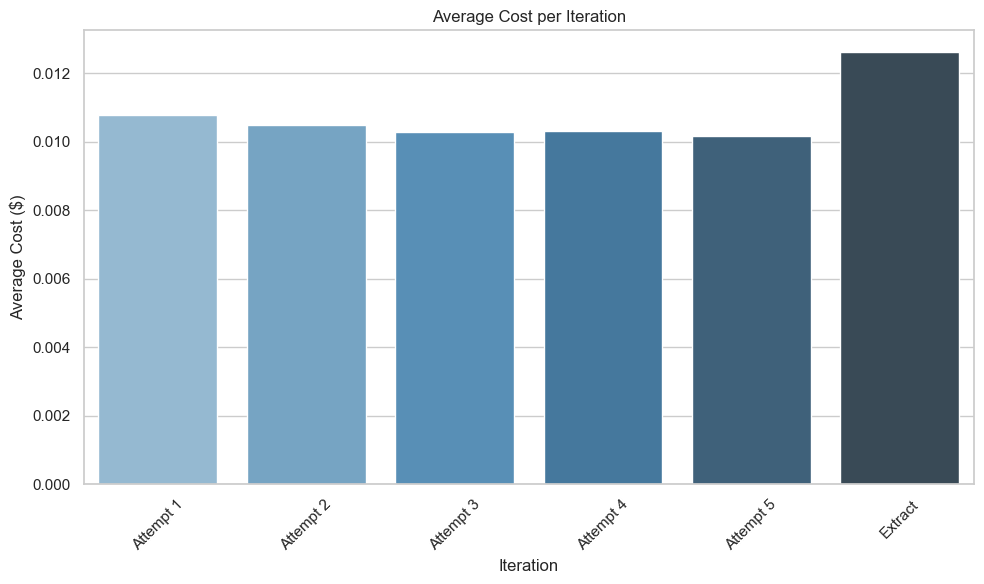

In [33]:
# Calculate cost per iteration
iteration_costs = usage_df.groupby("Step")["cost"].mean().reset_index()

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=iteration_costs, x="Step", y="cost", palette="Blues_d")
plt.title("Average Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Average Cost ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 5.4 Feature Extraction Success Rates <a id="5.4"></a>



#### 5.4.1 Successful Extraction Rate per Feature


/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_16674/483569748.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=success_rates.index, y=success_rates.values, palette="Greens_d")


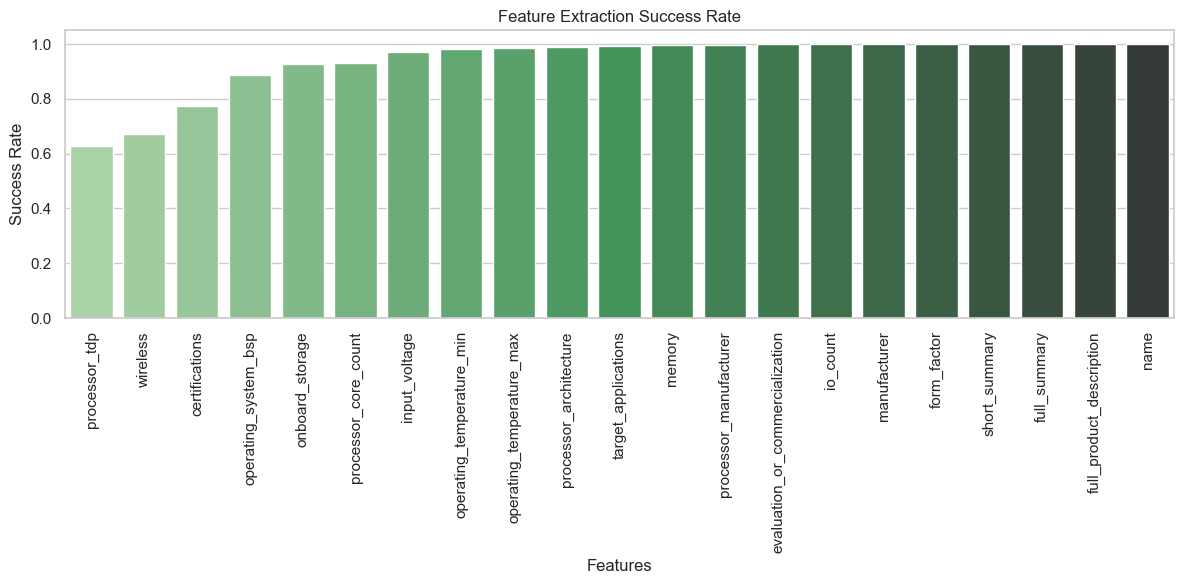

In [34]:
# Calculate success rate (non-missing rate) per feature
success_rates = 1 - missing_rates

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=success_rates.index, y=success_rates.values, palette="Greens_d")
plt.title("Feature Extraction Success Rate")
plt.xlabel("Features")
plt.ylabel("Success Rate")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


---

## 6. Conclusion <a id="6"></a>

- **Data Preparation:** We optimized the preprocessing steps by handling missing values, expanding extracted features, and aligning usage data.
- **Cost Calculations:** Confirmed that the cost calculations are accurate and consistent with the previous approach.
- **Exploratory Data Analysis:** Provided visualizations that offer insights into missing data patterns, cost and time distributions, and the effectiveness of iterative extraction steps.
- **Recommendations:**
  - **Optimize Iterations:** Consider limiting the number of extraction iterations to balance cost and diminishing returns.
  - **Focus on Key Features:** Prioritize improving extraction methods for features with high missing rates and high importance.
  - **Cost Monitoring:** Keep monitoring the cost distribution to identify and address outliers.



---



## 7. Save Processed Data <a id="7"></a>

We save the processed DataFrame for future analysis.

In [35]:
full_df.to_csv("../data/processed_feature_extraction_results.csv", index=False)
print("Processed data saved to 'processed_feature_extraction_results.csv'.")

Processed data saved to 'processed_feature_extraction_results.csv'.


In [36]:
final_df = full_df[["id"] + extracted_df.columns.tolist()]
final_df.head(1)

,id,name,manufacturer,form_factor,evaluation_or_commercialization,processor_architecture,processor_core_count,processor_manufacturer,processor_tdp,memory,onboard_storage,input_voltage,io_count,wireless,operating_system_bsp,operating_temperature_max,operating_temperature_min,certifications,short_summary,full_summary,full_product_description,target_applications
0,iW-G27S-SCQM-4L004G-E016G-BIC,IMX QUAD MAX QUAD PLUS PICO ITX SBC,IWAVE SYSTEMS,PICO ITX,False,ARM,6,NXP,NaN,Up to 8GB LPDDR4,Up to 64GB eMMC,12V,"[USB 3.0, USB 2.0, HDMI, Ethernet, PCIe, CAN, UART, SPI, I2C, MIPI CSI, MIPI DSI, LVDS]","[Wi-Fi, Bluetooth]","[Linux, Android Pie, QNX]",85°C,-40°C,"[RoHS, REACH]","The iMX Quad Max Quad Plus Pico ITX SBC is a high-performance, compact single board computer designed for industrial and embedded applications.","The iMX Quad Max Quad Plus Pico ITX SBC integrates dual Cortex-A72 and Cortex-A53 cores, dual GPUs, and a VPU for enhanced multimedia capabilities. It supports up to 8GB LPDDR4 memory and 64GB eMMC storage, with extensive I/O options including USB, HDMI, Ethernet, and wireless connectivity.","The iMX Quad Max Quad Plus Pico ITX SBC is engineered for high-performance applications in industrial, automotive, and medical domains. It features a robust set of interfaces including dual Ethernet, multiple USB ports, PCIe, and advanced display outputs like HDMI and MIPI DSI. The board supports Linux, Android Pie, and QNX operating systems, making it versatile for various development needs.","[Remote Energy Management, Intelligent Edge, Augmented and Virtual Reality, 4K Media Streaming, Industrial Automation, Automotive eCockpit]"


In [37]:
products_df = pd.read_csv("../data/feature_extraction/processed_products_df.csv")
products_df.columns

Index(['id', 'raw_data', 'raw_length', 'duplicate_ids'], dtype='object')

In [38]:
# we need to add duplicate_ids column to extracted_df, from products_df, where id is the same
products_df = products_df[["id", "duplicate_ids"]]
final_df = final_df.merge(products_df, on="id", how="left")

# rename the id column to product_id
final_df.rename(columns={"id": "product_id"}, inplace=True)

final_df.shape
final_df.head(1)

,product_id,name,manufacturer,form_factor,evaluation_or_commercialization,processor_architecture,processor_core_count,processor_manufacturer,processor_tdp,memory,onboard_storage,input_voltage,io_count,wireless,operating_system_bsp,operating_temperature_max,operating_temperature_min,certifications,short_summary,full_summary,full_product_description,target_applications,duplicate_ids
0,iW-G27S-SCQM-4L004G-E016G-BIC,IMX QUAD MAX QUAD PLUS PICO ITX SBC,IWAVE SYSTEMS,PICO ITX,False,ARM,6,NXP,NaN,Up to 8GB LPDDR4,Up to 64GB eMMC,12V,"[USB 3.0, USB 2.0, HDMI, Ethernet, PCIe, CAN, UART, SPI, I2C, MIPI CSI, MIPI DSI, LVDS]","[Wi-Fi, Bluetooth]","[Linux, Android Pie, QNX]",85°C,-40°C,"[RoHS, REACH]","The iMX Quad Max Quad Plus Pico ITX SBC is a high-performance, compact single board computer designed for industrial and embedded applications.","The iMX Quad Max Quad Plus Pico ITX SBC integrates dual Cortex-A72 and Cortex-A53 cores, dual GPUs, and a VPU for enhanced multimedia capabilities. It supports up to 8GB LPDDR4 memory and 64GB eMMC storage, with extensive I/O options including USB, HDMI, Ethernet, and wireless connectivity.","The iMX Quad Max Quad Plus Pico ITX SBC is engineered for high-performance applications in industrial, automotive, and medical domains. It features a robust set of interfaces including dual Ethernet, multiple USB ports, PCIe, and advanced display outputs like HDMI and MIPI DSI. The board supports Linux, Android Pie, and QNX operating systems, making it versatile for various development needs.","[Remote Energy Management, Intelligent Edge, Augmented and Virtual Reality, 4K Media Streaming, Industrial Automation, Automotive eCockpit]","['iW-G27S-SCQM-4L004G-E016G-BIC', 'iW-G27S-SCQM-4L008G-E032G-BIC']"


In [39]:
# save extracted_df
final_df.to_csv("../data/processed_feature_extraction_results.csv", index=False)
print("Processed data saved to 'processed_feature_extraction_results.csv'.")

Processed data saved to 'processed_feature_extraction_results.csv'.



---